In [1]:
import sys
sys.executable

'C:\\Users\\xiaog\\Anaconda3\\envs\\python3.6\\python.exe'

In [5]:
import numpy as np
import jieba
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import pandas as pd
%matplotlib inline

In [6]:
model = KeyedVectors.load_word2vec_format('sgns.zhihu.bigram',binary=False)

In [7]:
# 词向量维度
embedding_dim = model['吴京'].shape[0]
print(embedding_dim)

300


In [12]:
# 读取数据
data = pd.read_csv("../source/douban.txt",encoding='gb18030')
data.head()

,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


### 使用comment内容预测star，1-3为差评，4-5为好评

In [13]:
comments = data['comment'].tolist()
# 存储所有评论

In [14]:
star = data['star'].tolist()
# 存储所有评分

In [15]:
star.remove('star')
comments.remove('comment')
# 数据中混入了奸细

In [16]:
len(star)
# 评论总数量

261496

In [17]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,GRU,Embedding,LSTM,Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard,ReduceLROnPlateau

In [18]:
stopwords = '[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+'
# comment = re.sub(stopwords,'',comments[0])

In [19]:
# 分词和tokenrize
# 将分层后的结果转化成索引，在词向量中找不到索引的输出0，，大于num_words的也输出0
num_words = 50000
train_tokens = []
for comment in comments:
    comment = re.sub('[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+','',str(comment))
    cut_list = [word for word in jieba.cut(str(comment)) if word not in stopwords]
    cut_index = [i for i in cut_list]
    for i,word_ in enumerate(cut_list):
        try:
            idx = model.vocab[word_].index
            if idx<num_words:
                cut_index[i] = idx
            else:
                cut_index[i] = 0
        except KeyError:
            cut_index[i] = 0
    train_tokens.append(cut_index)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\xiaog\AppData\Local\Temp\jieba.cache
Loading model cost 1.063 seconds.
Prefix dict has been built succesfully.


In [21]:
train_tokens

[[4792, 7533, 48, 3, 3196, 1, 4721, 52, 3, 2603, 62, 3043],
 [0,
  52,
  1,
  163,
  2776,
  3,
  36,
  196,
  21640,
  1,
  222,
  25,
  4792,
  15,
  836,
  13,
  36,
  95,
  9382,
  1,
  1234,
  1563,
  198,
  1847,
  18396,
  10968,
  2954,
  1070,
  1020,
  190,
  5174,
  1569,
  16,
  1568,
  295,
  72,
  2053,
  31449],
 [4792,
  1,
  5021,
  606,
  0,
  14351,
  0,
  630,
  114,
  71,
  8730,
  58,
  5021,
  4792,
  55,
  12,
  52,
  3,
  10,
  1647,
  157,
  8730,
  78,
  8730,
  157,
  10635,
  78,
  10635,
  55,
  12,
  65,
  13,
  4,
  14,
  73,
  10626,
  73,
  7529,
  234,
  0,
  954,
  2093,
  1649,
  679,
  11046,
  1565,
  280,
  1649,
  758,
  7098,
  4179,
  8107,
  3295,
  1741,
  110,
  278,
  2861,
  10626,
  1,
  8730,
  10635,
  1427,
  532,
  24436,
  78,
  70,
  6242],
 [0, 72, 130, 0, 54, 0, 280, 61, 1, 24083, 0, 54, 11046, 1565, 61],
 [0, 34],
 [17, 2111, 6, 3259, 431, 0, 9146, 31, 4792, 131, 0, 241, 507, 7533, 0],
 [2270, 4, 14, 72, 152, 276, 4179, 181, 11,

In [22]:
len_tokens = [len(tokens) for tokens in train_tokens]
# 存储评论长度字典的列表

In [23]:
# 最长评论
np.max(len_tokens)

1970

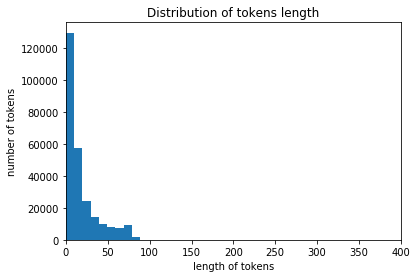

In [24]:
plt.hist(len_tokens,bins=200)
plt.xlim(0,400)
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [25]:
# 取comments平均值加两个comments的标准差
# 假设comments长度的分布为正态分布，则max_comments可以覆盖95%左右的样本
max_tokens = np.mean(len_tokens)+2*np.std(len_tokens)
max_tokens = int(max_tokens)
max_tokens

57

In [26]:
under_max = [num for num in len_tokens if num<max_tokens]
len(under_max)/len(len_tokens)

0.9217770061492336

In [27]:
# 不太符合，设max_token为60
max_tokens = 68
under_max = [num for num in len_tokens if num<max_tokens]
len(under_max)/len(len_tokens)

0.9543052283782544

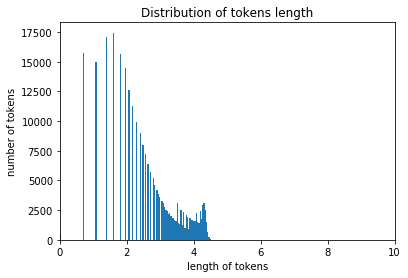

In [28]:
plt.hist(np.log(len_tokens+np.ones(len(len_tokens))),bins=200)
plt.xlim(0,10)
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()
# 确实不是正态分布

In [29]:
# 将tokens转化为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i !=0:
            text = text + model.index2word[i]
        else:
            text = text + ''
    return text

In [30]:
reverse = reverse_tokens(train_tokens[10])

In [31]:
reverse

'犯我中华者诛是有多无脑才信话'

In [32]:
comments[10]

'犯我中华者虽远必诛，是有多无脑才信这句话。'

### 准备词向量矩阵 (numwords,embeddingdim) 词汇数量*词向量维度

In [33]:
embedding_dim
# 词向量维度

300

In [34]:

# 初始化embedding_matrix为50000*300的零矩阵
embedding_matrix = np.zeros((num_words,embedding_dim))

# 把最常见的前50k词作为词向量
for i in range(num_words):
    embedding_matrix[i,:] = model[model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [36]:
embedding_matrix[0][0]

-0.801784

In [37]:
np.sum(model[model.index2word[333]] == embedding_matrix[333])

300

### padding and truncating 填充和修剪
为方便训练模型，需要把索引长度标准化，使用38为训练长度，涵盖95%的样本

填充和修剪选择在前面填充‘pre’

In [38]:
# 输入：list  train_tokens
# 输出：numpy array  train_pad 
train_pad = pad_sequences(train_tokens,maxlen=max_tokens,padding='pre',truncating='pre')

In [39]:
train_pad[2]
# 填充之后前面是0

array([    0,  4792,     1,  5021,   606,     0, 14351,     0,   630,
         114,    71,  8730,    58,  5021,  4792,    55,    12,    52,
           3,    10,  1647,   157,  8730,    78,  8730,   157, 10635,
          78, 10635,    55,    12,    65,    13,     4,    14,    73,
       10626,    73,  7529,   234,     0,   954,  2093,  1649,   679,
       11046,  1565,   280,  1649,   758,  7098,  4179,  8107,  3295,
        1741,   110,   278,  2861, 10626,     1,  8730, 10635,  1427,
         532, 24436,    78,    70,  6242])

In [40]:
train_target = [int(i)//4 for i in star]

In [41]:
train_target

[0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,


In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_pad,train_target,
                                                test_size=0.3,random_state=12)
# 随机种子random_state 保证每次打乱顺序的结果一样

In [44]:
print(reverse_tokens(X_train[73]))
print('class:',y_train[73])

时空类电影而且比较严谨了加上片中对未来科技的幻想
class: 1


### 使用keras搭建LSTM模型

In [45]:
# tokens索引转换为词向量矩阵之后，可以使用神经网络对文本进行处理
# keras的Embedding接口可以避免稀疏矩阵的操作
Lmodel = Sequential()
# 第一层为embedding
Lmodel.add(Embedding(num_words,embedding_dim,weights=[embedding_matrix],
                     input_length=max_tokens,trainable=False))
# num_words?

In [46]:
# 第二层bidirectional层 有32个单元，每一步返回一个sequence 双向LSTM 返回64维
Lmodel.add(Bidirectional(LSTM(units=32,return_sequences=True)))
# 第三层单向LSTM层 不返回sequence 
Lmodel.add(LSTM(units=16,return_sequences=False))

In [47]:
# 第四层全连接层 sigmoid激活函数
Lmodel.add(Dense(1,activation='sigmoid'))
# 使用Adam以learning rate进行优化
optimizer = Adam(lr=1e-3)

In [48]:
Lmodel.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [49]:
Lmodel.summary()
# 模型结构

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 300)           15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 68, 64)            85248     
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                5184      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 15,090,449
Trainable params: 90,449
Non-trainable params: 15,000,000
_________________________________________________________________


In [50]:
# 建立权重存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint,monitor='val_loss',
                            verbose=1,save_weights_only=True,
                            save_best_only=True)

In [51]:
# 加载已训练模型
try:
    Lmodel.load_weights(path_checkpoint)
except Exception as e:
    print(e)

Unable to open file (unable to open file: name = 'sentiment_checkpoint.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


In [52]:
# 3个epoch内validation loss没有改善就停止训练
earlystopping = EarlyStopping(monitor='val_loss',patience=3,verbose=1)

In [53]:
# 自动降低学习速率
lr_reduction = ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                min_lr=1e-5,patience=0,verbose=1)

In [54]:
# 定义callback函数
callbacks = [
    earlystopping,
    checkpoint,
    lr_reduction
]

In [55]:
# 开始训练
# 交叉验证样本 0.7*0.1
Lmodel.fit(X_train,y_train,
         validation_split=0.1,
         epochs=20,
         batch_size=128,
         callbacks=callbacks)

Train on 164742 samples, validate on 18305 samples
Epoch 1/20
164736/164742 [============================>.] - ETA: 0s - loss: 0.6533 - accuracy: 0.6120
Epoch 00001: val_loss improved from inf to 0.63609, saving model to sentiment_checkpoint.keras
164742/164742 [==============================] - 472s 3ms/sample - loss: 0.6533 - accuracy: 0.6120 - val_loss: 0.6361 - val_accuracy: 0.6365
Epoch 2/20
164736/164742 [============================>.] - ETA: 0s - loss: 0.6293 - accuracy: 0.6425
Epoch 00002: val_loss improved from 0.63609 to 0.62187, saving model to sentiment_checkpoint.keras
164742/164742 [==============================] - 475s 3ms/sample - loss: 0.6293 - accuracy: 0.6425 - val_loss: 0.6219 - val_accuracy: 0.6482
Epoch 3/20
164736/164742 [============================>.] - ETA: 0s - loss: 0.6167 - accuracy: 0.6523
Epoch 00003: val_loss improved from 0.62187 to 0.61371, saving model to sentiment_checkpoint.keras
164742/164742 [==============================] - 474s 3ms/sample - l

In [56]:
result = Lmodel.evaluate(X_test,y_test)
print('Accuracy:{0:.2%}'.format(result[1]))

78449/78449 [==============================] - 131s 2ms/sample - loss: 0.5725 - accuracy: 0.6988
Accuracy:69.88%


In [57]:
y_pred = Lmodel.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p>=0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [58]:
y_true = np.array(y_test)

In [59]:
mistakes = np.where(y_pred != y_true)[0]

In [60]:
mistakes

array([    1,     5,    12, ..., 78444, 78445, 78447], dtype=int64)

In [61]:
idx = 5
print(reverse_tokens(X_test[idx]))
print('预测：',y_pred[idx])
print('实际：',y_true[idx])

1999公司VCD豆瓣
预测： 0
实际： 1


In [62]:
idx = 1
print(reverse_tokens(X_test[idx]))
print('预测：',y_pred[idx])
print('实际：',y_true[idx])

看到我就想到了女朋友
预测： 0
实际： 1


In [63]:
idx = 12
print(reverse_tokens(X_test[idx]))
print('预测：',y_pred[idx])
print('实际：',y_true[idx])

其实只有啦给给摄影但是的电影小成本制作一定要鼓励鼓励呀努力的男孩呢
预测： 1
实际： 0


In [64]:
idx = 78447
print(reverse_tokens(X_test[idx]))
print('预测：',y_pred[idx])
print('实际：',y_true[idx])

「」「」
预测： 1
实际： 0


### 预测失败的样本，本身情感色彩不是很明显